Here we will test our single view models and our multiview model using the generated data.

In [2]:
import os
import keras
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from transformers import AutoTokenizer, TFAutoModel
import tensorflow_datasets as tfds
from keras.datasets import mnist 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc, f1_score, accuracy_score

from PIL import Image
from keras.callbacks import EarlyStopping
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.models import Model

%load_ext autoreload
%autoreload 2

from utils import show_performance_metrics, preprocess_image, augment_image, apply_augmentation

2025-08-23 00:07:46.309819: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-23 00:07:46.327272: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI AVX512_BF16, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/config/anaconda3/envs/imperial_3_12_linux/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# --- Configuration ---
# Image dimensions for ResNet50 input
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3 # ResNet50 expects 3 channels (RGB)

# Batch size for training
BATCH_SIZE = 16 

# Number of epochs for training the classifier head
EPOCHS = 30

# Learning rate for the classifier head
LEARNING_RATE = 1e-4

# Seed used for splitting the train, validation and test dataset 
seed = 11

In [4]:
# ---  Data Loading from CSV ---
# Load CSV file
try:
    df = pd.read_csv('../handwriting_generation/dyslexia_handwriting_dataset.csv')
    print("--- Successfully loaded dyslexia_handwriting_dataset.csv ---")
except FileNotFoundError:
    print("Error: 'dyslexia_handwriting_dataset.csv' not found. Please ensure the CSV file is in the same directory as the script.")
    exit()

if 'file_path' not in df.columns or 'text' not in df.columns or 'presence_of_dyslexia' not in df.columns:
    print("Error: CSV must contain 'file_path', 'text', and 'presence_of_dyslexia' columns.")
    exit()

# Convert labels to integer type
df['presence_of_dyslexia'] = df['presence_of_dyslexia'].astype(int)

print("--- DataFrame Head ---")
print(df.head())
print("\n--- Value Counts for Dyslexia Presence ---")
print(df['presence_of_dyslexia'].value_counts())

--- Successfully loaded dyslexia_handwriting_dataset.csv ---
--- DataFrame Head ---
   presence_of_dyslexia                                          file_path  \
0                     0  ../data/normal_handwriting_images/normal_sampl...   
1                     0  ../data/normal_handwriting_images/normal_sampl...   
2                     0  ../data/normal_handwriting_images/normal_sampl...   
3                     0  ../data/normal_handwriting_images/normal_sampl...   
4                     0  ../data/normal_handwriting_images/normal_sampl...   

                                                text  
0  My best friend, Violet, has a navy pet hedgeho...  
1  My best friend, Kevin, has a silver pet parrot...  
2  My best friend, George, has a navy pet fish. G...  
3  My best friend, Mia, has a gold pet budgie. Mi...  
4  My best friend, Laura, has a yellow pet hamste...  

--- Value Counts for Dyslexia Presence ---
presence_of_dyslexia
0    500
1    500
Name: count, dtype: int64


# 1  Single View model Using Images


Total files: 1000
Training files: 700 (70.0%)
Validation files: 150 (15.0%)
Test files: 150 (15.0%)

--- tf.data.Dataset created successfully ---

--- Model Summary (Initial Frozen Layers) ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


--- Training the model for 30 epochs ---
Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 218ms/step - accuracy: 0.8732 - loss: 0.2702 - val_accuracy: 0.9733 - val_loss: 0.0666
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.9806 - loss: 0.0601 - val_accuracy: 0.9867 - val_loss: 0.0560
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.9862 - loss: 0.0350 - val_accuracy: 0.9733 - val_loss: 0.0597
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accuracy: 0.9904 - loss: 0.0204 - val_accuracy: 0.9867 - val_loss: 0.0630
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.9936 - loss: 0.0159 - val_accuracy: 0.9800 - val_loss: 0.0459
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accuracy: 0.9985 - loss: 0.0090 - val_accuracy: 0.9800 - val_loss: 0.0534
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accuracy: 0.9952 - loss: 0.0142 - val_accuracy: 0.9867 - val_loss: 0.0527
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accurac

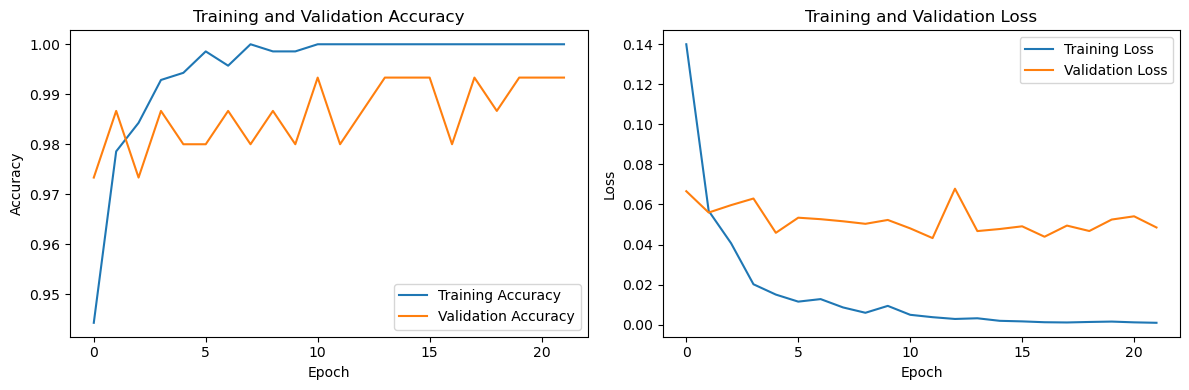


Confusion Matrix:


2025-08-23 00:11:36.318863: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


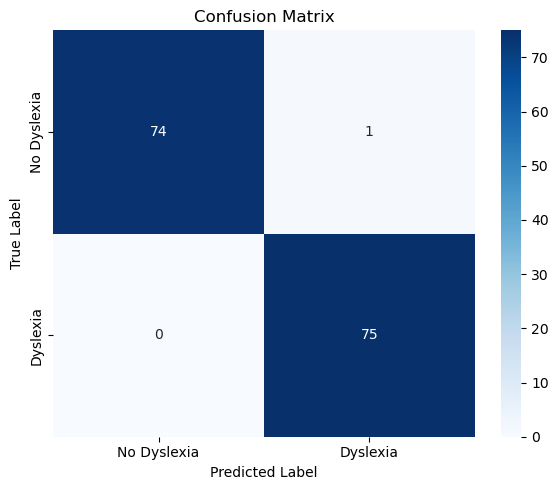


Additional Metrics for Test Results:
Sensitivity (Recall): 1.0000
Specificity: 0.9867
F1 Score: 0.9934

Classification Report:
              precision    recall  f1-score   support

 No Dyslexia       1.00      0.99      0.99        75
    Dyslexia       0.99      1.00      0.99        75

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

ROC AUC Score (Prob-based): 0.9998
PR AUC Score: 0.9998


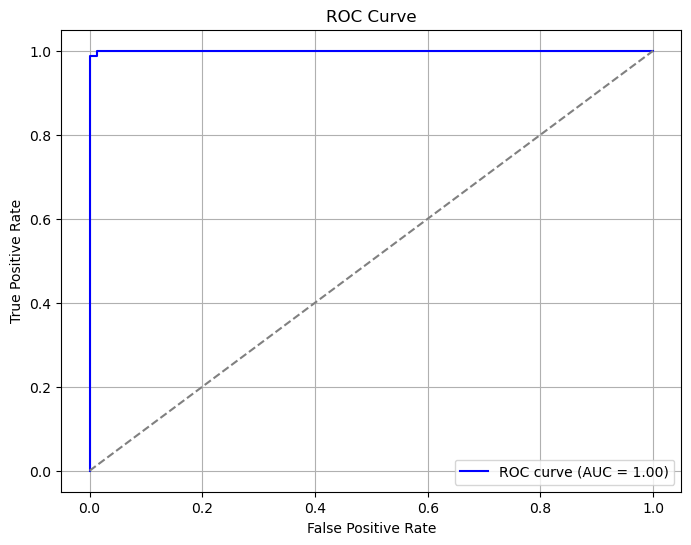

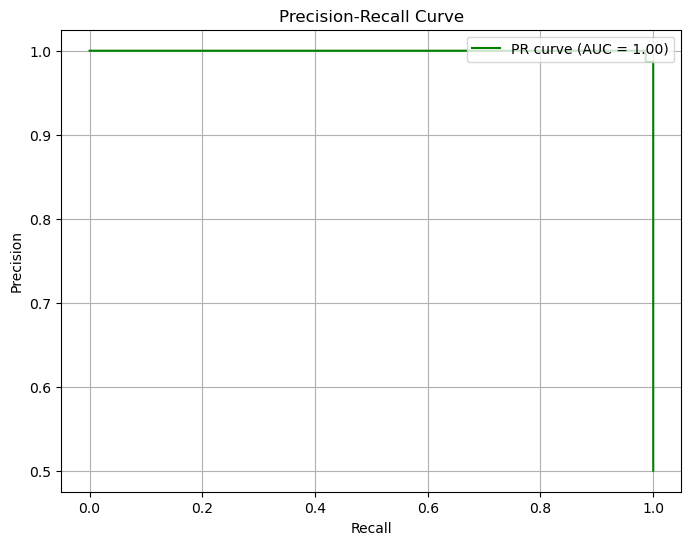

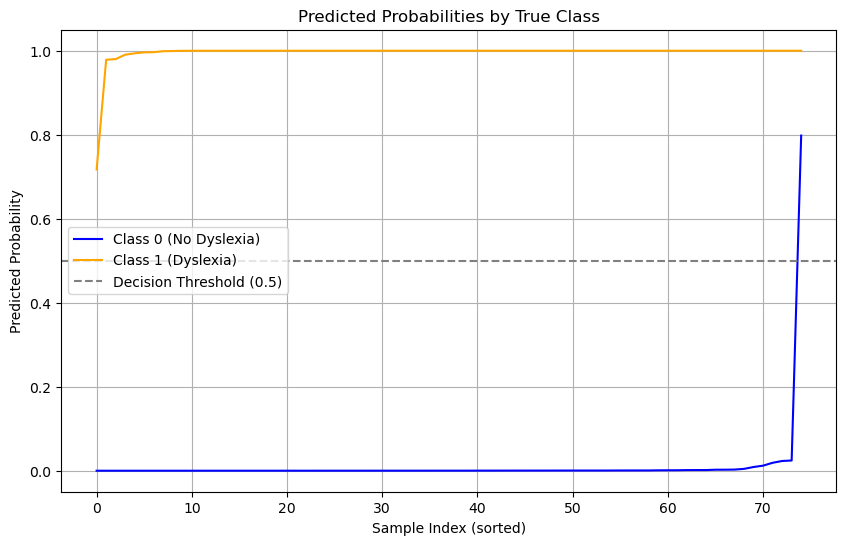

In [5]:
# Create Single View model using handwriting images 

# ---  Data Splitting ---
# 70% Training, 15% Validation, 15% Testing

# Split into training and (validation + test)
train_df, val_test_df = train_test_split(
    df,
    test_size=0.3, 
    stratify=df['presence_of_dyslexia'], # Maintain class distribution
    random_state=seed
)

# Then, split (validation + test) into validation and test
val_df, test_df = train_test_split(
    val_test_df,
    test_size=0.5, 
    stratify=val_test_df['presence_of_dyslexia'], # Maintain class distribution
    random_state=seed
)

print(f"\nTotal files: {len(df)}")
print(f"Training files: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation files: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test files: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

# ---  Image Preprocessing and tf.data.Dataset creation ---

# Create tf.data.Dataset from DataFrames
def create_dataset(dataframe, augment=False, shuffle=False):
    # Convert file_path and presence_of_dyslexia columns to TensorFlow tensors
    file_paths = tf.constant(dataframe['file_path'].tolist())
    labels = tf.constant(dataframe['presence_of_dyslexia'].tolist(), dtype=tf.float32) 

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe), seed=seed)

    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE) # Prefetch for performance
    return dataset

train_dataset = create_dataset(train_df, augment=False, shuffle=True)
validation_dataset = create_dataset(val_df, augment=False, shuffle=False)
test_dataset = create_dataset(test_df, augment=False, shuffle=False)

print("\n--- tf.data.Dataset created successfully ---")

# --- Model Building (ResNet50 for Binary Classification) ---
# Load ResNet50 model with pre-trained ImageNet weights, excluding the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model layers to prevent their weights from being updated during initial training.
# This uses the pre-learned features from ImageNet as-is.
base_model.trainable = False

# Add custom classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x) # Reduces spatial dimensions to 1x1, capturing global features
x = Dense(256, activation='relu')(x) # A dense layer before the final output
predictions = Dense(1, activation='sigmoid')(x) # Output layer for binary classification

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
# Using Adam optimizer, binary_crossentropy for binary classification, and accuracy as metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("\n--- Model Summary (Initial Frozen Layers) ---")
model.summary()

# ---  Model Training ---
epochs = EPOCHS 
# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
print(f"\n--- Training the model for {EPOCHS} epochs ---")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=[early_stopping_callback]
)

# Fine-tuning (unfreeze some layers and train again with a lower learning rate)
# Possible for small datasets to adapt the pre-trained features.
'''print("\n--- Fine-tuning: Unfreezing top layers of ResNet50 ---")
base_model.trainable = True # Unfreeze the base model

# Can unfreeze a small number of layers from the top of the base model
# and keep the lower layers (earlier layers) frozen, as they learn more generic features.
# Can experiment with different numbers of layers to unfreeze.
# The `len(base_model.layers) - 50`  unfreezes the last 50 layers.
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), # Very low learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("\n--- Model Summary (After Unfreezing) ---")
model.summary()

# Continue training for a few more epochs
fine_tune_epochs = 10
total_epochs = epochs + fine_tune_epochs

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print(f"\n--- Fine-tuning the model for {fine_tune_epochs} more epochs ---")
history_fine_tune = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # Start from where previous training left off
    validation_data=validation_dataset,
    callbacks=[early_stopping_callback]
)'''

# --- Model Evaluation ---
print("\n--- Evaluating the model on the test set ---")
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# --- Save the model ---
# model_save_path = 'dyslexia_detection_resnet50.h5'
# model.save(model_save_path)
# print(f"\nModel saved to {model_save_path}")

# ---  Visualize Training History ---
# Combine history from initial training and fine-tuning
acc = history.history['accuracy'] #+ history_fine_tune.history['accuracy']
val_acc = history.history['val_accuracy'] #+ history_fine_tune.history['val_accuracy']
loss = history.history['loss'] #+ history_fine_tune.history['loss']
val_loss = history.history['val_loss'] #+ history_fine_tune.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
# --- Gather predictions and true labels ---
all_probs = []
all_labels = []

for images, labels in test_dataset:
    probs = model.predict(images, verbose=0).flatten()
    all_probs.extend(probs)
    all_labels.extend(labels.numpy())

# --- Show final performance metrics ---
show_performance_metrics(all_labels, all_probs)


# 2  Single View model using transcript text 

Loading BERT tokenizer and tokenizing all text...


/config/anaconda3/envs/imperial_3_12_linux/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


All text tokenized. Input IDs shape: (1000, 128), Attention Masks shape: (1000, 128)
Training samples: 700
Validation samples: 150
TensorFlow Datasets created from preprocessed NumPy arrays for text.
Building single-view text model architecture...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

BERT model wrapped in custom layer and layers frozen.
Compiling text model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_feature_extra… │ (None, 768)       │          0 │ attention_mask[0… │
│ (BertEmbeddingLaye… │                   │            │ input_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    196,864 │ bert_feature_ext… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │        257 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 197,121 (770.00 KB)

 Trainable params: 197,121 (770.00 KB)

 Non-trainable params: 0 (0.00 B)

Training text model...
Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 512ms/step - accuracy: 0.7109 - loss: 0.5563 - val_accuracy: 0.9733 - val_loss: 0.2196
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 490ms/step - accuracy: 0.9316 - loss: 0.2726 - val_accuracy: 0.9733 - val_loss: 0.1429
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 491ms/step - accuracy: 0.9491 - loss: 0.1840 - val_accuracy: 0.9733 - val_loss: 0.1184
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 489ms/step - accuracy: 0.9496 - loss: 0.1692 - val_accuracy: 0.9733 - val_loss: 0.1045
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 489ms/step - accuracy: 0.9576 - loss: 0.1567 - val_accuracy: 0.9733 - val_loss: 0.0978
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 489ms/step - accuracy: 0.9628 - loss: 0.1475 - val_accuracy: 0.9733 - val_loss: 0.0908
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 489ms/step - accuracy: 0.9574 - loss: 0.1471 - val_accuracy: 0.9733 - val_loss: 0.0877
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 491ms/step - accuracy: 0.9639 - 

2025-08-23 00:22:37.912021: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


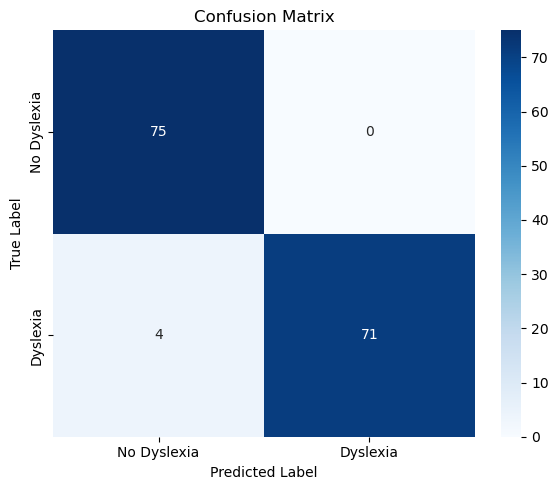


Additional Metrics for Test Results:
Sensitivity (Recall): 0.9467
Specificity: 1.0000
F1 Score: 0.9726

Classification Report:
              precision    recall  f1-score   support

 No Dyslexia       0.95      1.00      0.97        75
    Dyslexia       1.00      0.95      0.97        75

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150

ROC AUC Score (Prob-based): 0.9692
PR AUC Score: 0.9825


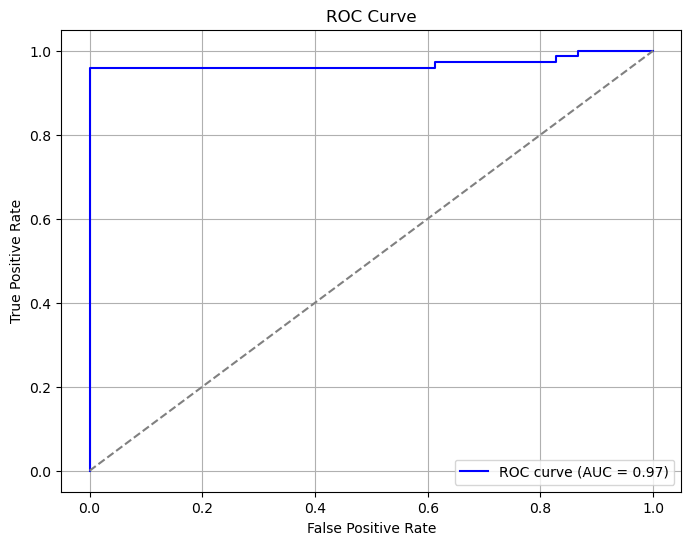

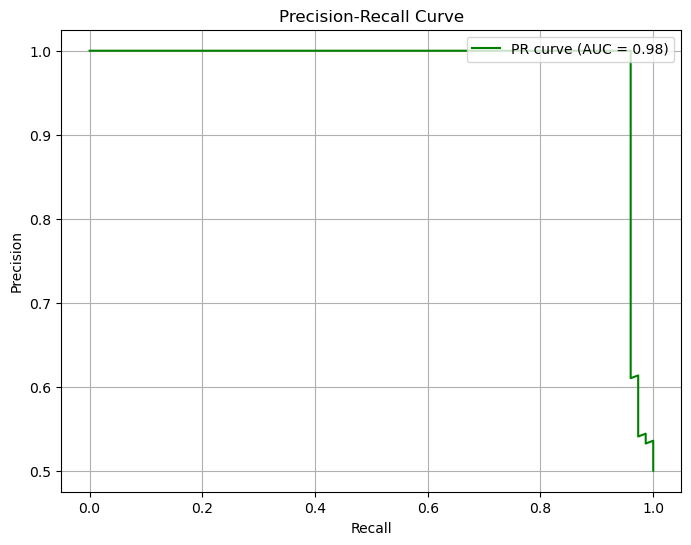

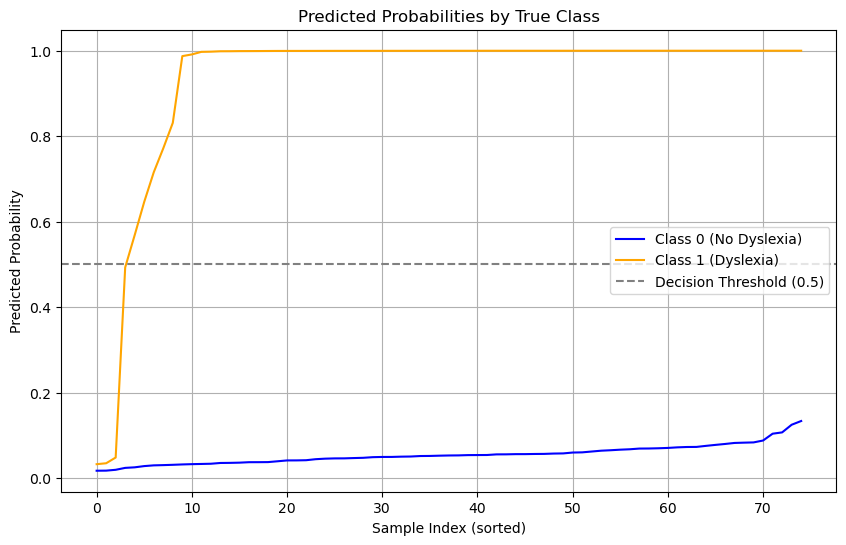


Text single-view model training and evaluation complete.


In [6]:
# Create Single View model using transcript text 
# --- Text Tokenization (Pre-tokenizing all text) ---
print("Loading BERT tokenizer and tokenizing all text...")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased") 

all_input_ids = []
all_attention_masks = []

for text_entry in df['text']:
    encoded_input = tokenizer(
        text_entry,
        padding='max_length',
        truncation=True,
        max_length=128, # Consistent max length
        return_tensors='np'  
    )
    all_input_ids.append(encoded_input['input_ids'][0])
    all_attention_masks.append(encoded_input['attention_mask'][0])

all_input_ids = np.array(all_input_ids)
all_attention_masks = np.array(all_attention_masks)
print(f"All text tokenized. Input IDs shape: {all_input_ids.shape}, Attention Masks shape: {all_attention_masks.shape}")

# ---  Split Processed data: 70% Train, 15% Validation, 15% Test for Text Data ---

#  Split into Training (70%) and Temporary (30%)
X_input_ids_train, X_input_ids_temp, \
X_attention_masks_train, X_attention_masks_temp, \
y_train, y_temp = train_test_split(
    all_input_ids,
    all_attention_masks,
    df['presence_of_dyslexia'].values, 
    test_size=0.3, 
    random_state=seed,
    stratify=df['presence_of_dyslexia'].values # Stratify based on the full labels
)

# Step 2: Split the Temporary set (30%) into Validation (15%) and Test (15%)
X_input_ids_val, X_input_ids_test, \
X_attention_masks_val, X_attention_masks_test, \
y_val, y_test = train_test_split(
    X_input_ids_temp,
    X_attention_masks_temp,
    y_temp,  
    test_size=0.5,  
    random_state=seed,  
    stratify=y_temp # Stratify based on the labels from the temp set
)

print(f"Training samples: {len(y_train)}")
print(f"Validation samples: {len(y_val)}")

# --- Create TensorFlow Datasets from NumPy arrays (for text only) ---
def create_tf_text_dataset_from_np(input_ids, attention_masks, labels):
    """
    Creates a TensorFlow Dataset from NumPy arrays for text data.
    """
    ds = tf.data.Dataset.from_tensor_slices(
        (
            {'input_ids': input_ids, 'attention_mask': attention_masks},
            labels
        )
    )
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset_text = create_tf_text_dataset_from_np(X_input_ids_train, X_attention_masks_train, y_train)
val_dataset_text = create_tf_text_dataset_from_np(X_input_ids_val, X_attention_masks_val, y_val)
test_dataset_text = create_tf_text_dataset_from_np(X_input_ids_test, X_attention_masks_test, y_test)

print("TensorFlow Datasets created from preprocessed NumPy arrays for text.")

# --- Custom Keras Layer for BERT Model (re-used from multi-view) ---
class BertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, model_name, **kwargs):
        super().__init__(**kwargs)
        self.bert_model = TFAutoModel.from_pretrained(model_name, from_pt=True) 
        self.bert_model.trainable = False # Keep BERT layers frozen for feature extraction

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        # The training=False argument is crucial to prevent issues with symbolic tensors
        bert_output = self.bert_model(input_ids, attention_mask=attention_mask, training=False)
        # The [CLS] token output is typically at index 0 of the last_hidden_state
        return bert_output.last_hidden_state[:, 0, :]

    def get_config(self):
        config = super().get_config()
        config.update({"model_name": "bert-base-cased"})  
        return config

# --- Define the Single-View Text Model ---
print("Building single-view text model architecture...")

# Text Branch (BERT) using the custom layer
bert_input_ids = keras.Input(shape=(128,), dtype=tf.int32, name='input_ids')
bert_attention_mask = keras.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

bert_embedding_extractor = BertEmbeddingLayer("bert-base-cased", name="bert_feature_extractor") 
text_features = bert_embedding_extractor({'input_ids': bert_input_ids, 'attention_mask': bert_attention_mask})
print("BERT model wrapped in custom layer and layers frozen.")

# Classifier Head (New layers to be trained)
classifier_head = layers.Dense(256, activation='relu')(text_features)
classifier_head = layers.Dropout(0.5)(classifier_head)
'''classifier_head = layers.Dense(128, activation='relu')(classifier_head)
classifier_head = layers.Dropout(0.3)(classifier_head)'''
output_layer = layers.Dense(1, activation='sigmoid', name='output')(classifier_head)

# Create the final single-view text model
text_model = keras.Model(
    inputs={'input_ids': bert_input_ids, 'attention_mask': bert_attention_mask},
    outputs=output_layer
)

# --- Compile and Train the Text Model ---
print("Compiling text model...")
text_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

text_model.summary()

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("Training text model...")
history_text = text_model.fit(
    train_dataset_text,
    epochs=EPOCHS,
    validation_data=val_dataset_text,
    callbacks=[early_stopping_callback]
)

# --- Evaluation for Text Model ---
print("\nEvaluating text model on validation set...")
test_loss_text, test_accuracy_text = text_model.evaluate(test_dataset_text)
print(f"Text Model Test Loss: {test_loss_text:.4f}")
print(f"Text Model Test Accuracy: {test_accuracy_text:.4f}")

# Generate predictions and classification report for text model
all_preds_text = []
all_labels_text = []
# Create a dataset for prediction from validation data for text
predict_dataset_text = tf.data.Dataset.from_tensor_slices(
    (
        {'input_ids': X_input_ids_test, 'attention_mask': X_attention_masks_test},
        y_test
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for inputs, labels in predict_dataset_text:
    predictions = text_model.predict(inputs)
    all_preds_text.extend(predictions.flatten().tolist())
    all_labels_text.extend(labels.numpy().flatten().tolist())

# Convert probabilities to binary predictions (0 or 1)
binary_preds_text = np.array(all_preds_text) > 0.5

print("\nClassification Report (Text Model):")
print(classification_report(all_labels_text, binary_preds_text))

print("\nConfusion Matrix (Text Model):")
print(confusion_matrix(all_labels_text, binary_preds_text))

# --- Show final performance metrics ---
show_performance_metrics(all_labels_text, all_preds_text)

print("\nText single-view model training and evaluation complete.")

# 3 Multiview model using both handwriting and transcript text 

Total samples: 1000
Loading and preprocessing all images...
All images loaded. Shape: (1000, 224, 224, 3)
Loading BERT tokenizer and tokenizing all text...
All text tokenized. Input IDs shape: (1000, 128), Attention Masks shape: (1000, 128)


/config/anaconda3/envs/imperial_3_12_linux/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Training samples: 700
Validation samples: 150
Test samples: 150
TensorFlow Datasets created from preprocessed NumPy arrays.
Building multi-modal model architecture...
ResNet50 model loaded and layers frozen.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

BERT model wrapped in custom layer and layers frozen.
Compiling model...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ image_input[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 26,473,345 (100.99 MB)

 Trainable params: 2,885,633 (11.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Training model...
Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 705ms/step - accuracy: 0.8342 - loss: 0.3296 - val_accuracy: 1.0000 - val_loss: 0.0277
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 662ms/step - accuracy: 0.9919 - loss: 0.0484 - val_accuracy: 1.0000 - val_loss: 0.0180
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 663ms/step - accuracy: 0.9892 - loss: 0.0323 - val_accuracy: 1.0000 - val_loss: 0.0141
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 661ms/step - accuracy: 0.9933 - loss: 0.0256 - val_accuracy: 1.0000 - val_loss: 0.0098
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 662ms/step - accuracy: 0.9950 - loss: 0.0211 - val_accuracy: 1.0000 - val_loss: 0.0130
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 667ms/step - accuracy: 0.9967 - loss: 0.0172 - val_accuracy: 1.0000 - val_loss: 0.0066
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 662ms/step - accuracy: 0.9976 - loss: 0.0126 - val_accuracy: 1.0000 - val_loss: 0.0081
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 662ms/step - accuracy: 0.9981 - loss:

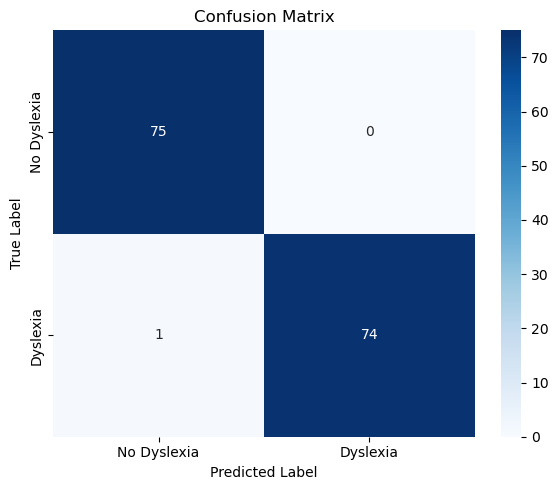


Additional Metrics for Test Results:
Sensitivity (Recall): 0.9867
Specificity: 1.0000
F1 Score: 0.9933

Classification Report:
              precision    recall  f1-score   support

 No Dyslexia       0.99      1.00      0.99        75
    Dyslexia       1.00      0.99      0.99        75

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

ROC AUC Score (Prob-based): 1.0000
PR AUC Score: 1.0000


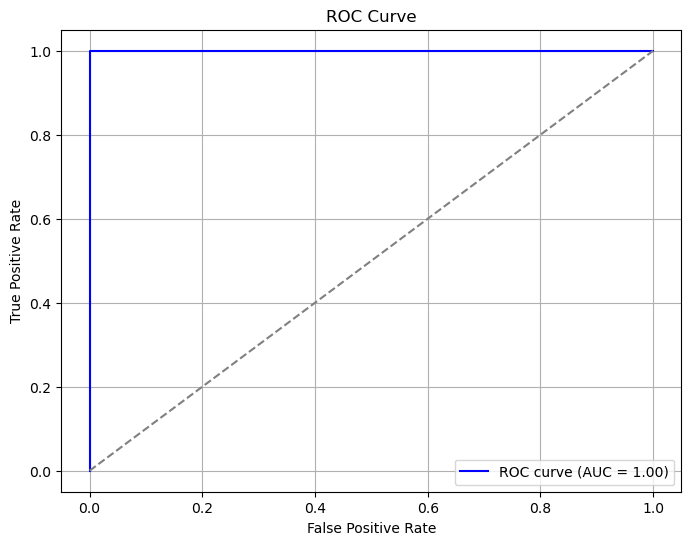

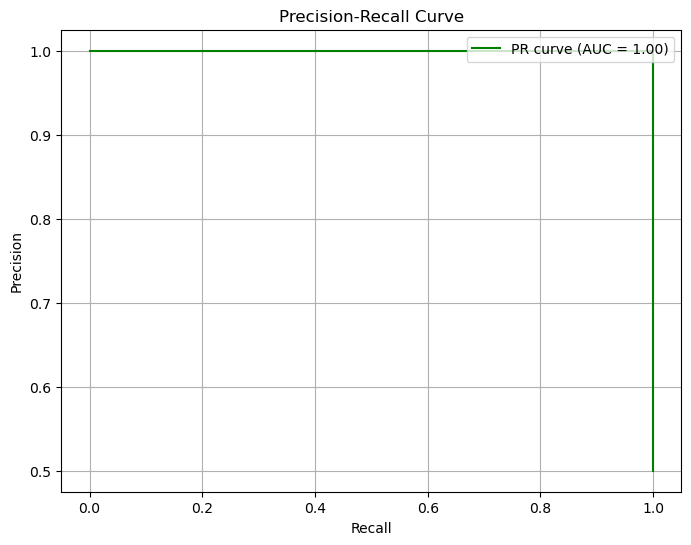

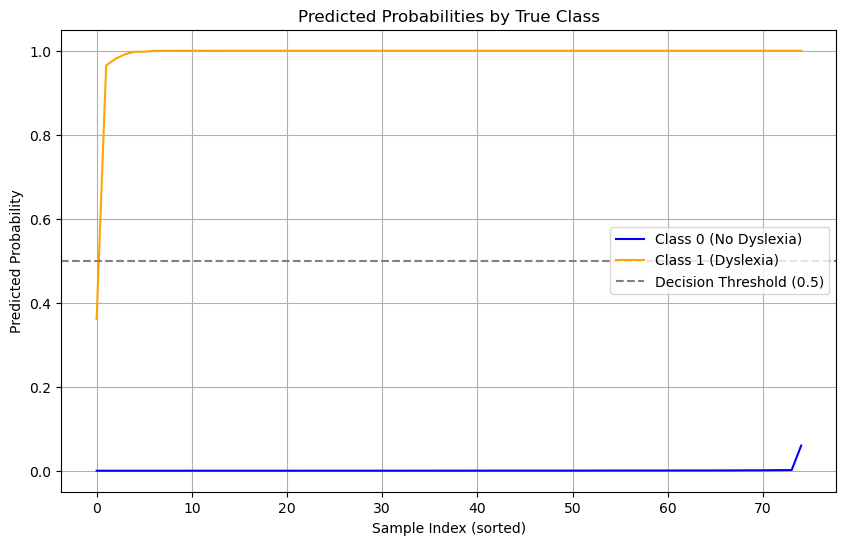


Model training and evaluation complete.


In [7]:
# Create MultiView model using both handwriting and transcript text 

df['text'] = df['text'].fillna('').astype(str) # Fill NaN with empty string, then convert to str
print(f"Total samples: {len(df)}")

# --- Image Preprocessing (Pre-loading all images) ---
print("Loading and preprocessing all images...")
all_images = []
for index, row in df.iterrows():
    image_path = row['file_path']
    full_image_path = image_path  
    try:
        # Load image file
        img = tf.io.read_file(full_image_path)
        # Decode image 
        img = tf.image.decode_jpeg(img, channels=3)  
        # Resize image
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
        # Apply ResNet50 specific preprocessing
        img = tf.keras.applications.resnet50.preprocess_input(img)
        all_images.append(img)
    except Exception as e:
        print(f"Error loading image {full_image_path}: {e}. Appending black image placeholder.")
        all_images.append(np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32))

all_images = np.array(all_images)
print(f"All images loaded. Shape: {all_images.shape}")

# --- Text Tokenization (Pre-tokenizing all text) ---
print("Loading BERT tokenizer and tokenizing all text...")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

all_input_ids = []
all_attention_masks = []

for text_entry in df['text']:
    encoded_input = tokenizer(
        text_entry,  
        padding='max_length',
        truncation=True,
        max_length=128, # Consistent max length
        return_tensors='np'  
    )
    # Access the first (and only) item in the batch dimension [0]
    all_input_ids.append(encoded_input['input_ids'][0])
    all_attention_masks.append(encoded_input['attention_mask'][0])

all_input_ids = np.array(all_input_ids)
all_attention_masks = np.array(all_attention_masks)
print(f"All text tokenized. Input IDs shape: {all_input_ids.shape}, Attention Masks shape: {all_attention_masks.shape}")

# Step 1: Split into Training (70%) and Temporary (30%)
X_images_train, X_images_temp, \
X_input_ids_train, X_input_ids_temp, \
X_attention_masks_train, X_attention_masks_temp, \
y_train, y_temp = train_test_split(
    all_images,
    all_input_ids,
    all_attention_masks,
    df['presence_of_dyslexia'].values,
    test_size=0.3, 
    random_state=seed,
    stratify=df['presence_of_dyslexia'].values
)

# Split the Temporary set (30%) into Validation (15%) and Test (15%)
X_images_val, X_images_test, \
X_input_ids_val, X_input_ids_test, \
X_attention_masks_val, X_attention_masks_test, \
y_val, y_test = train_test_split(
    X_images_temp,
    X_input_ids_temp,
    X_attention_masks_temp,
    y_temp,
    test_size=0.5, 
    random_state=seed, 
    stratify=y_temp # Stratify based on the labels of the temp set
)

print(f"Training samples: {len(y_train)}")
print(f"Validation samples: {len(y_val)}")
print(f"Test samples: {len(y_val)}")

# --- Create TensorFlow Datasets from NumPy arrays ---
def create_tf_dataset_from_np(images, input_ids, attention_masks, labels, augment=False):
    """
    Creates a TensorFlow Dataset from NumPy arrays.
    Applies augmentation as a TensorFlow operation if specified.
    """
    ds = tf.data.Dataset.from_tensor_slices(
        (
            {'image_input': images, 'input_ids': input_ids, 'attention_mask': attention_masks},
            labels
        )
    )

    if augment:
        def apply_augmentation(inputs, label):
            img = inputs['image_input']
            # Apply random augmentation for training images using TF ops
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, max_delta=0.2)
            img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
            
            inputs['image_input'] = img
            return inputs, label
        ds = ds.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = create_tf_dataset_from_np(X_images_train, X_input_ids_train, X_attention_masks_train, y_train, augment=False)
val_dataset = create_tf_dataset_from_np(X_images_val, X_input_ids_val, X_attention_masks_val, y_val, augment=False)
test_dataset = create_tf_dataset_from_np(X_images_test, X_input_ids_test, X_attention_masks_test, y_test, augment=False)


print("TensorFlow Datasets created from preprocessed NumPy arrays.")

# --- Custom Keras Layer for BERT Model ---
class BertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, model_name, **kwargs):
        super().__init__(**kwargs)
        self.bert_model = TFAutoModel.from_pretrained(model_name, from_pt=True) 
        self.bert_model.trainable = False

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        # The training=False argument is crucial to prevent issues with symbolic tensors
        bert_output = self.bert_model(input_ids, attention_mask=attention_mask, training=False)
        # The [CLS] token output is typically at index 0 of the last_hidden_state
        return bert_output.last_hidden_state[:, 0, :]

    def get_config(self):
        config = super().get_config()
        config.update({"model_name": "bert-base-cased"}) 
        return config

# --- Define the Multi-Modal Model ---
print("Building multi-modal model architecture...")

# Image Branch (ResNet50)
resnet_input = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='image_input')
resnet_model = keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=resnet_input
)

# Freeze ResNet50 layers
resnet_model.trainable = False
print("ResNet50 model loaded and layers frozen.")

# Extract features from ResNet50 output
image_features = resnet_model.output
image_features = layers.GlobalAveragePooling2D()(image_features)

# Text Branch (BERT) using the custom layer
bert_input_ids = keras.Input(shape=(128,), dtype=tf.int32, name='input_ids')
bert_attention_mask = keras.Input(shape=(128,), dtype=tf.int32, name='attention_mask')

bert_embedding_extractor = BertEmbeddingLayer("bert-base-cased", name="bert_feature_extractor")
text_features = bert_embedding_extractor({'input_ids': bert_input_ids, 'attention_mask': bert_attention_mask})
print("BERT model wrapped in custom layer and layers frozen.")

# Concatenate features from both modalities
concatenated_features = layers.Concatenate()([image_features, text_features])

# Classifier Head (New layers to be trained)
'''classifier_head = layers.Dense(256, activation='relu')(concatenated_features)
classifier_head = layers.Dropout(0.3)(classifier_head)
classifier_head = layers.Dense(128, activation='relu')(classifier_head)
classifier_head = layers.Dropout(0.3)(classifier_head)
output_layer = layers.Dense(1, activation='sigmoid', name='output')(classifier_head)'''
# Late fusion: combine the two modalities, decided 1024 , as we have the feature vectors as 2048 (image) + 768 (text)
fusion = layers.Dense(1024, activation='relu')(concatenated_features)
fusion = layers.Dropout(0.5)(fusion)
# Final binary classification
output_layer = layers.Dense(1, activation='sigmoid', name='output')(fusion)

# Create the final multi-modal model
model = keras.Model(
    inputs={'image_input': resnet_input, 'input_ids': bert_input_ids, 'attention_mask': bert_attention_mask},
    outputs=output_layer
)

# --- Compile and Train the Model ---
print("Compiling model...")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

model.summary()

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("Training model...")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping_callback]
)

# --- Evaluation ---
print("\nEvaluating model on Test set...")
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions and classification report
all_preds = []
all_labels = []
# Create a dataset for prediction from validation data
predict_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {'image_input': X_images_test, 'input_ids': X_input_ids_test, 'attention_mask': X_attention_masks_test},
        y_test
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for inputs, labels in predict_dataset:
    predictions = model.predict(inputs)
    all_preds.extend(predictions.flatten().tolist())
    all_labels.extend(labels.numpy().flatten().tolist())

# Convert probabilities to binary predictions (0 or 1)
binary_preds = np.array(all_preds) > 0.5

print("\nClassification Report:")
print(classification_report(all_labels, binary_preds))

print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, binary_preds))

# --- Show final performance metrics ---
show_performance_metrics(all_labels, all_preds)

print("\nModel training and evaluation complete.")


# 4 Test with Small Scale dataset 

Testing LFFC on Small Scale Dataset
--- Successfully loaded dyslexia_data.csv ---
--- DataFrame Head ---
   id  presence_of_dyslexia  \
0   0                     1   
1   1                     1   
2   2                     1   
3   3                     1   
4   4                     1   

                                           file_path  text  
0  ./dlsathvik04/Dyslexia_Detection/data/dyslexic...   NaN  
1  ./dlsathvik04/Dyslexia_Detection/data/dyslexic...   NaN  
2  ./dlsathvik04/Dyslexia_Detection/data/dyslexic...   NaN  
3  ./dlsathvik04/Dyslexia_Detection/data/dyslexic...   NaN  
4  ./dlsathvik04/Dyslexia_Detection/data/dyslexic...   NaN  

--- Value Counts for Dyslexia Presence ---
presence_of_dyslexia
1    50
0    50
Name: count, dtype: int64
Loading data from CSV...
Total samples: 95
Loading and preprocessing all images...
All images loaded. Shape: (95, 224, 224, 3)
Loading BERT tokenizer and tokenizing all text...
All text tokenized. Input IDs shape: (95, 128), Attention 

/config/anaconda3/envs/imperial_3_12_linux/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 540ms/step - accuracy: 0.8315 - loss: 0.5004
Test Loss: 0.6859
Test Accuracy: 0.7789
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.75      0.77        48
           1       0.76      0.81      0.78        47

    accuracy                           0.78        95
   macro avg       0.78      0.78      0.78        95
weighted avg       0.78      0.78      0.78        95


Confusion Matrix:
[[36 12]
 [ 9 38]]

Confusion Matrix:


2025-08-23 00:37:54.243440: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


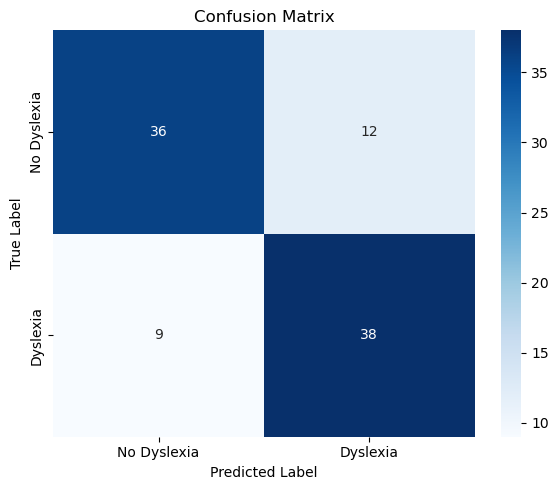


Additional Metrics for Test Results:
Sensitivity (Recall): 0.8085
Specificity: 0.7500
F1 Score: 0.7835

Classification Report:
              precision    recall  f1-score   support

 No Dyslexia       0.80      0.75      0.77        48
    Dyslexia       0.76      0.81      0.78        47

    accuracy                           0.78        95
   macro avg       0.78      0.78      0.78        95
weighted avg       0.78      0.78      0.78        95

ROC AUC Score (Prob-based): 0.8506
PR AUC Score: 0.8634


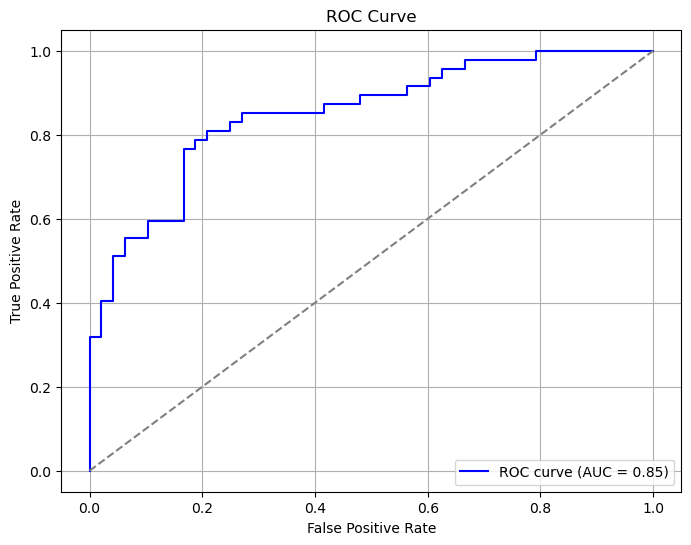

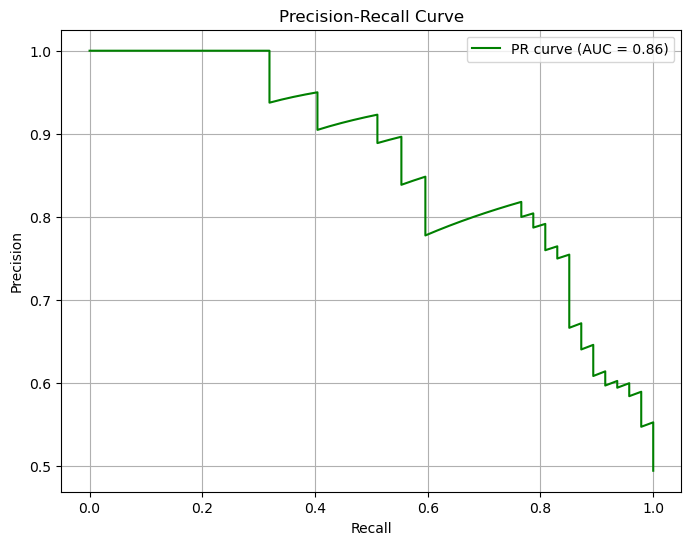

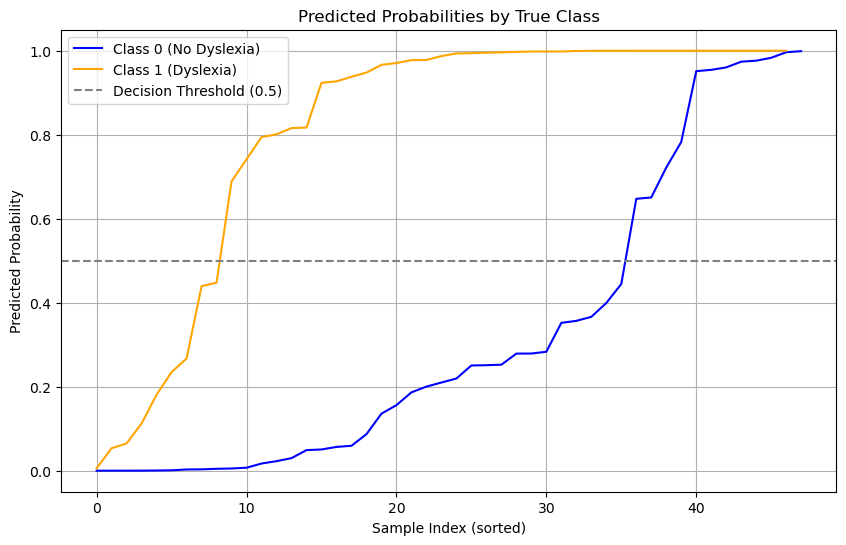


Model training and evaluation complete.


In [8]:
print("Testing LFFC on Small Scale Dataset")
# Load small scale dataset 
try:
    df = pd.read_csv('dyslexia_data.csv')
    print("--- Successfully loaded dyslexia_data.csv ---")
except FileNotFoundError:
    print("Error: 'dyslexia_data.csv' not found. Please ensure the CSV file is in the same directory as the script.")
    exit()

# Ensure the 'file_path' column exists
if 'file_path' not in df.columns:
    print("Error: 'file_path' column not found in dyslexia_data.csv.")
    exit()
if 'presence_of_dyslexia' not in df.columns:
    print("Error: 'presence_of_dyslexia' column not found in dyslexia_data.csv.")
    exit()

print("--- DataFrame Head ---")
print(df.head())
print("\n--- Value Counts for Dyslexia Presence ---")
print(df['presence_of_dyslexia'].value_counts())

# --- Image Preprocessing and tf.data.Dataset creation ---
BATCH_SIZE = 16 
RELATIVE_DIR = '../../..'

# Function to load and preprocess images
def preprocess_image(image_path, label):
    # Load image file
    full_image_path = tf.strings.join([RELATIVE_DIR, "/", image_path])
    img = tf.io.read_file(full_image_path)
    # Decode image 
    img = tf.image.decode_jpeg(img, channels=3) 
    # Resize image
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    # Apply ResNet50 specific preprocessing
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img, label

# Create tf.data.Dataset from DataFrames
def create_dataset(dataframe, augment=False, shuffle=False):
    # Convert file_path and presence_of_dyslexia columns to TensorFlow tensors
    file_paths = tf.constant(dataframe['file_path'].tolist())
    labels = tf.constant(dataframe['presence_of_dyslexia'].tolist(), dtype=tf.float32) 

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe), seed=seed)

    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE) # Prefetch for performance
    return dataset

train_dataset = create_dataset(train_df, augment=False, shuffle=True)

# Evaluate using the LFFC model trained on the generate dataset

# --- Configuration ---
IMG_DIR = '../../..' 

# Path to CSV file
CSV_FILE_PATH = 'dyslexia_data_with_text_duplicates_removed.csv' 

# Batch size for training
BATCH_SIZE = 16 

# --- Load and Prepare Data ---
print("Loading data from CSV...")
try:
    df = pd.read_csv(CSV_FILE_PATH)
except FileNotFoundError:
    print(f"Error: CSV file not found at {CSV_FILE_PATH}. Please check the path.")
    exit()

if 'file_path' not in df.columns or 'text' not in df.columns or 'presence_of_dyslexia' not in df.columns:
    print("Error: CSV must contain 'file_path', 'text', and 'presence_of_dyslexia' columns.")
    exit()

df['text'] = df['text'].fillna('').astype(str) # Fill NaN with empty string, then convert to str

# Convert labels to integer type
df['presence_of_dyslexia'] = df['presence_of_dyslexia'].astype(int)

print(f"Total samples: {len(df)}")

# --- Image Preprocessing (Pre-loading all images) ---
print("Loading and preprocessing all images...")
all_images = []
for index, row in df.iterrows():
    image_path = row['file_path']
    full_image_path = os.path.join(IMG_DIR, image_path)
    try:
        # Load image file
        img = tf.io.read_file(full_image_path)
        # Decode image 
        img = tf.image.decode_jpeg(img, channels=3)  
        # Resize image
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
        # Apply ResNet50 specific preprocessing
        img = tf.keras.applications.resnet50.preprocess_input(img)
        all_images.append(img)
    except Exception as e:
        print(f"Error loading image {full_image_path}: {e}. Appending black image placeholder.")
        all_images.append(np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32))

all_images = np.array(all_images)
print(f"All images loaded. Shape: {all_images.shape}")

# --- Text Tokenization (Pre-tokenizing all text) ---
print("Loading BERT tokenizer and tokenizing all text...")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

all_input_ids = []
all_attention_masks = []

for text_entry in df['text']:
    encoded_input = tokenizer(
        text_entry, 
        padding='max_length',
        truncation=True,
        max_length=128, 
        return_tensors='np' 
    )
    # Access the first (and only) item in the batch dimension [0]
    all_input_ids.append(encoded_input['input_ids'][0])
    all_attention_masks.append(encoded_input['attention_mask'][0])

all_input_ids = np.array(all_input_ids)
all_attention_masks = np.array(all_attention_masks)
print(f"All text tokenized. Input IDs shape: {all_input_ids.shape}, Attention Masks shape: {all_attention_masks.shape}")

# --- Split Preprocessed Data into Train, Validation, and Test Sets ---
print("Splitting data into training, validation, and test sets...")

# --- Create TensorFlow Datasets from NumPy arrays ---
def create_tf_dataset_from_np(images, input_ids, attention_masks, labels, augment=False):
    """
    Creates a TensorFlow Dataset from NumPy arrays.
    Applies augmentation as a TensorFlow operation if specified.
    """
    ds = tf.data.Dataset.from_tensor_slices(
        (
            {'image_input': images, 'input_ids': input_ids, 'attention_mask': attention_masks},
            labels
        )
    )

    if augment:
        def apply_augmentation(inputs, label):
            img = inputs['image_input']
            # Apply random augmentation for training images using TF ops
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, max_delta=0.2)
            img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
            # More complex augmentations could be added using TensorFlow operations
            
            inputs['image_input'] = img
            return inputs, label
        ds = ds.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

preliminary_test_dataset = create_tf_dataset_from_np(all_images, all_input_ids, all_attention_masks, df['presence_of_dyslexia'].values, augment=False)

# --- Evaluation ---
print("\nEvaluating model on Preliminary Small Scale Test set...")
test_loss, test_accuracy = model.evaluate(preliminary_test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions and classification report
all_preds = []
all_labels = []

for inputs, labels in preliminary_test_dataset:
    predictions = model.predict(inputs)
    all_preds.extend(predictions.flatten().tolist())
    all_labels.extend(labels.numpy().flatten().tolist())

# Convert probabilities to binary predictions (0 or 1)
binary_preds = np.array(all_preds) > 0.5

print("\nClassification Report:")
print(classification_report(all_labels, binary_preds))

print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, binary_preds))

# --- Show final performance metrics ---
show_performance_metrics(all_labels, all_preds)

print("\nModel training and evaluation complete.")
